# Se discreto
Anton Hurtado - Problema Individual Lista 2

## Apartado A

Instalamos Machine Learning Benchmark para acceder al dataset *appendicitis*.

In [3]:
!pip3 install pmlb

Importamos las librerías que necesitaremos a lo largo de la práctica.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmlb import fetch_data
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

Cargamos el dataset *appendicitis*.

In [5]:
appendicitis_data = fetch_data('appendicitis')
appendicitis_data.head()

,At1,At2,At3,At4,At5,At6,At7,target
0,0.213,0.554,0.207,0.000,0.000,0.749,0.220,1
1,0.458,0.714,0.468,0.111,0.102,0.741,0.436,1
2,0.102,0.518,0.111,0.056,0.022,0.506,0.086,1
3,0.187,0.196,0.105,0.056,0.029,0.133,0.085,1
4,0.236,0.804,0.289,0.111,0.066,0.756,0.241,1


Dividimos los datos en entrenamiento y test (60% y 40% respectivamente), fijando el estado del generador de números aleatorios a 42.

In [6]:
X = appendicitis_data.loc[:,appendicitis_data.columns != 'target']
y = appendicitis_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

## Apartado B

Preprocesamos los datos de train y de test.

In [7]:
def preprocessing(X):
    X_preprocessed = X.copy(deep=True)
    scaler = StandardScaler()
    X_preprocessed = scaler.fit_transform(X_preprocessed)
    return X_preprocessed

In [8]:
X_train_preprocessed = preprocessing(X_train)
X_test_preprocessed = preprocessing(X_test)

Función para entrenar y evaluar el modelo con sus respectivos posibles hiperparámetros. Obtenemos el acierto de validación cruzada, el acierto de test, la matriz de confusión y el informe de clasificación.

In [9]:
def train_model(model, params, X_train, y_train, X_test, y_test):
    # Encontramos los mejores hiperparámetros
    grid_search = GridSearchCV(model, params, cv=10, scoring='accuracy');
    grid_search.fit(X_train, y_train);

    # Acierto de Validación Cruzada
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=10)
    cv_accuracy = np.mean(cv_scores)

    # Acierto en Test
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Matriz de Confusión
    confusion = confusion_matrix(y_test, y_pred)

    # Informe de Clasificación
    report = classification_report(y_test, y_pred, output_dict=True)

    return cv_accuracy, test_accuracy, confusion, report

Asignamos los diferentes hiperparámetros a los modelos, para posteriormente al entrenarlos ver que combinación da mejores resultados.

In [10]:
# Gaussian Naive Bayes no tiene hiperparámetros para ajustar
nb_params = {}

# Parámetros para Regresión Logística
lr_params = [
    {'C': 10**np.linspace(-3, 3, 21, endpoint=True), 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']},
    {'C': 10**np.linspace(-3, 3, 21, endpoint=True), 'penalty': ['l1'], 'solver': ['liblinear']}
]

# Parámetros para K-NN
knn_params = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

Obtenemos los datos para los diferentes modelos.

In [11]:
gnb_cv_accuracy, gnb_test_accuracy, gnb_confusion_matrix, gnb_classification_report = train_model(GaussianNB(), nb_params, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
lr_cv_accuracy, lr_test_accuracy, lr_confusion_matrix, lr_classification_report = train_model(LogisticRegression(), lr_params, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
knn_cv_accuracy, knn_test_accuracy, knn_confusion_matrix, knn_classification_report = train_model(KNeighborsClassifier(), knn_params, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

In [12]:
data = {
    'Acierto Validación Cruzada': [gnb_cv_accuracy, lr_cv_accuracy, knn_cv_accuracy],
    'Acierto en Test': [gnb_test_accuracy, lr_test_accuracy, knn_test_accuracy]
}

df = pd.DataFrame(data, index=['Naive Bayes', 'Regresión Logística', 'K-NN'])
print(df)

                     Acierto Validación Cruzada  Acierto en Test
Naive Bayes                            0.888095         0.837209
Regresión Logística                    0.921429         0.837209
K-NN                                   0.919048         0.860465


Podemos observar en la tabla que K-NN tiene la mejor generalización, por su alto rendimiento tato en validación cruzada (91'9%) como en test (86'0%). La Regresión Logística por su parte, presenta una validación cruzada ligeramente superior (92'1%) pero con un acierto de test menor (83'7%), lo que evidencia un posible sobreajuste durante el entrenamiento. Naive Bayes, aunque presente el menor acierto de validación cruzada (88'8%), consigue unos resultados iguales a los de la regresión logística en los aciertos de test (83'7%).

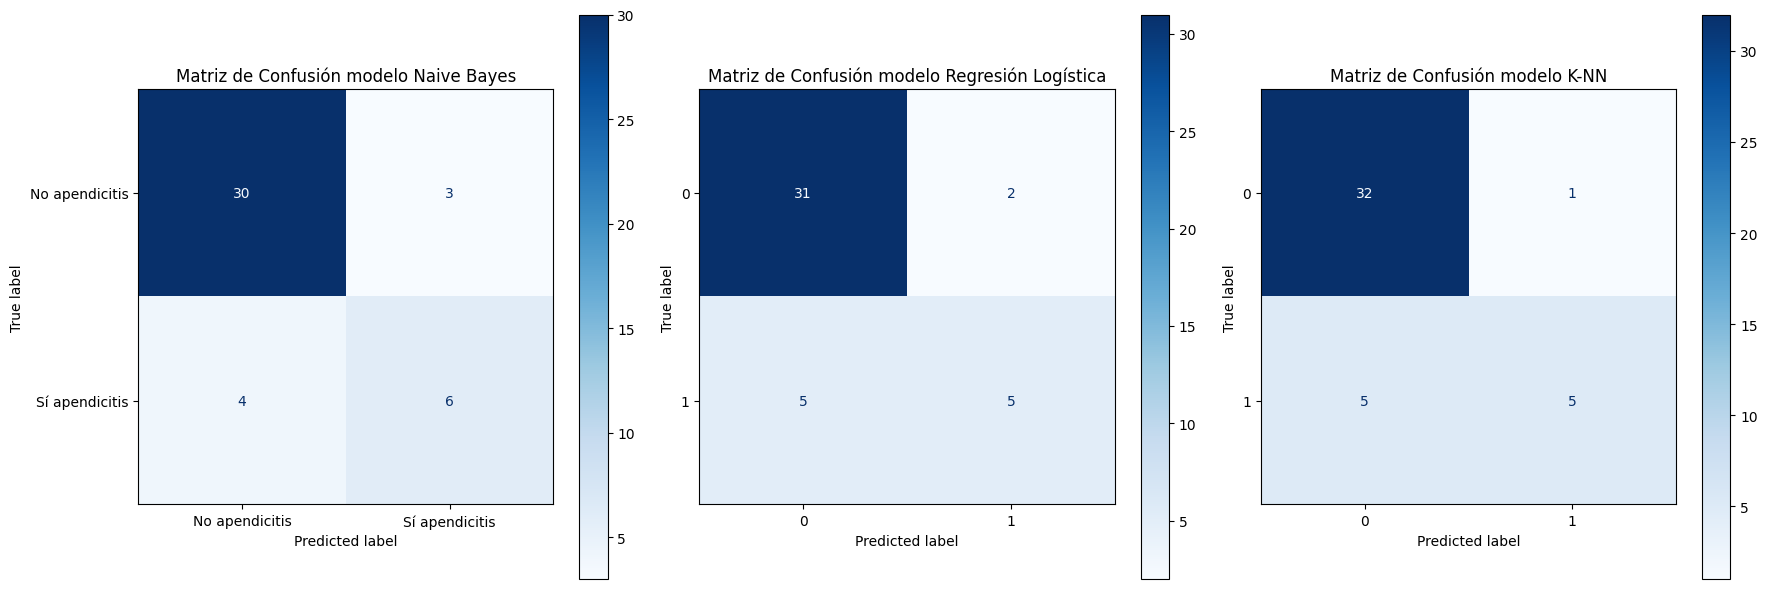

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Naive Bayes
disp = ConfusionMatrixDisplay(confusion_matrix=gnb_confusion_matrix, display_labels=['No apendicitis', 'Sí apendicitis'])
disp.plot(cmap='Blues', ax=axes[0])
axes[0].set_title("Matriz de Confusión modelo Naive Bayes")

# Regresión Logística
disp = ConfusionMatrixDisplay(confusion_matrix=lr_confusion_matrix, display_labels=['0', '1'])
disp.plot(cmap='Blues', ax=axes[1])
axes[1].set_title("Matriz de Confusión modelo Regresión Logística")

# K-NN
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_matrix, display_labels=['0', '1'])
disp.plot(cmap='Blues', ax=axes[2])
axes[2].set_title("Matriz de Confusión modelo K-NN")

plt.tight_layout()
plt.show()

En estas tablas vemos el rendimiento de los tres modelos. Las filas superiores representan los casos reales sin apendicitis y las inferiores con apendicitis. Las columnas indican nuestras predicciones.

Si consideramos prioritario minimizar la errónea asignación de no tener apendicitis, el mejor modelo es Naive Bayes.

Pero, si buscamos un balance más equitativo, K-NN es preferible por a su mejor rendimiento general.

In [17]:
df_gnb = pd.DataFrame(gnb_classification_report).transpose()
df_lr = pd.DataFrame(lr_classification_report).transpose()
df_knn = pd.DataFrame(knn_classification_report).transpose()

combined_df = pd.concat([df_gnb.add_suffix(' (GNB)'), df_lr.add_suffix(' (LR)'), df_knn.add_suffix(' (KNN)')], axis=1)
print(combined_df)

              precision (GNB)  recall (GNB)  f1-score (GNB)  support (GNB)  \
0                    0.882353      0.909091        0.895522      33.000000   
1                    0.666667      0.600000        0.631579      10.000000   
accuracy             0.837209      0.837209        0.837209       0.837209   
macro avg            0.774510      0.754545        0.763551      43.000000   
weighted avg         0.832193      0.837209        0.834140      43.000000   

              precision (LR)  recall (LR)  f1-score (LR)  support (LR)  \
0                   0.861111     0.939394       0.898551     33.000000   
1                   0.714286     0.500000       0.588235     10.000000   
accuracy            0.837209     0.837209       0.837209      0.837209   
macro avg           0.787698     0.719697       0.743393     43.000000   
weighted avg        0.826966     0.837209       0.826384     43.000000   

              precision (KNN)  recall (KNN)  f1-score (KNN)  support (KNN)  
0        

El modelo K-Nearest Neighbors demuestra ser el más efectivo, con la mayor precisión y un rendimiento equilibrado en todas las métricas evaluadas, especialmente destacando en la clase 0 (no tener apendicitis). Naive Bayes (GNB), aunque presenta un buen equilibrio entre precisión y recall, es menos preciso en la clase 1 (tener apendicitis). La Regresión Logística (LR) sobresale en identificar la clase 0, pero su eficacia disminuye notablemente para la clase 1.

Podemos concluir entonces que, si queremos evitar las asignaciones erróneas de no apendicitis, el mejor modelo es Naive Bayes, y en caso de querer un rendimiento equilibrado, el modelo preferible es K-NN.

## Apartado C

Función que preprocesa los datos con KBinsDiscretizer en codificación onehot. La estrategia y n_bins los definimos por parámetros.

In [18]:
def discretized_preprocessing(X, n, strategy):
  X_discretized = X.copy(deep=True)

  # Aplicamos el KBinsDiscretizer
  discretizer = KBinsDiscretizer(n_bins=n, encode='onehot-dense', strategy=strategy)
  X_discretized = discretizer.fit_transform(X_discretized)

  scaler = StandardScaler()
  X_discretized = scaler.fit_transform(X_discretized)
  return X_discretized

Definimos la estrategia quantile y kmenas, con n_bins 2, 3 y 4.

Como hemos transformado las variables en binarias, dejan de seguir una distribución gausiana, por lo que pasamos de utilizar Gausssian NB a Bernoulli NB.

En la Regresión Logística, para algunos valores de C habrá problemas de convergencia con el solver lbfgs.

In [ ]:
from sklearn.naive_bayes import BernoulliNB

strategies = ['quantile', 'kmeans']
n_bins = [2, 3, 4]
discretized_datasets = {}
for strategy in strategies:
  for n in n_bins:
    X_train_discretized = discretized_preprocessing(X_train, n, strategy)
    X_test_discretized = discretized_preprocessing(X_test, n, strategy)

    key = f"{strategy}_{n}_bins"
    discretized_datasets[key] = {
        'X_train': X_train_discretized,
        'X_test': X_test_discretized,
        'bnb': train_model(BernoulliNB(), nb_params, X_train_discretized, y_train, X_test_discretized, y_test),
        'lr': train_model(LogisticRegression(), lr_params, X_train_discretized, y_train, X_test_discretized, y_test),
        'knn': train_model(KNeighborsClassifier(), knn_params, X_train_discretized, y_train, X_test_discretized, y_test)
    }

In [20]:
all_accuracy = []
all_confusion_matrix = []
for x in discretized_datasets:
  for y in ['bnb', 'lr', 'knn']:
    cv_accuracy = discretized_datasets[x][y][0]
    test_accuracy = discretized_datasets[x][y][1]
    all_accuracy.append({'Dataset': x, 'Model': y, 'Acierto Validación Cruzada': cv_accuracy, 'Acierto en Test': test_accuracy})

    confusion_matrix = discretized_datasets[x][y][2]
    all_confusion_matrix.append({'Dataset': x, 'Model': y, 'Confusion Matrix': confusion_matrix})


all_accuracy_df = pd.DataFrame(all_accuracy)
all_confusion_matrix_df = pd.DataFrame(all_confusion_matrix)

In [21]:
all_accuracy_df

,Dataset,Model,Acierto Validación Cruzada,Acierto en Test
0,quantile_2_bins,bnb,0.764286,0.813953
1,quantile_2_bins,lr,0.890476,0.813953
2,quantile_2_bins,knn,0.876190,0.813953
3,quantile_3_bins,bnb,0.807143,0.837209
4,quantile_3_bins,lr,0.861905,0.860465
5,quantile_3_bins,knn,0.919048,0.813953
6,quantile_4_bins,bnb,0.804762,0.813953
7,quantile_4_bins,lr,0.890476,0.813953
8,quantile_4_bins,knn,0.904762,0.860465
9,kmeans_2_bins,bnb,0.759524,0.720930


Comparando con la tabla del apartado B de los datos no discretizados podemos ver que:

Para el modelo Naive Bayes nunca se mejora el resultado, solo se iguala a los datos no discretizados cuando se aplica el quantile_3_bins llegando al 83'7%. Para el resto empeora el resultado.

Para el modelo de Regresión Logística se mejora el acierto de test respecto a los datos no discretizados cuando aplicamos la discretización quantile_3_bins o kmeans_3_bins, pasando del 83'% al 86'0%. Con la discretización kmeans_4_bins obtenemos el mismo porcentaje de acierto. Para el resto empeora.

Para el modelo KNN nunca se mejora el resultado, solo si iguala al aplicar el kmeans_4_bins o quantile_4_bins llegando al 86'0%. Para el resto empeora.

In [22]:
all_confusion_matrix_df

,Dataset,Model,Confusion Matrix
0,quantile_2_bins,bnb,"[[26, 7], [1, 9]]"
1,quantile_2_bins,lr,"[[30, 3], [5, 5]]"
2,quantile_2_bins,knn,"[[30, 3], [5, 5]]"
3,quantile_3_bins,bnb,"[[28, 5], [2, 8]]"
4,quantile_3_bins,lr,"[[31, 2], [4, 6]]"
5,quantile_3_bins,knn,"[[30, 3], [5, 5]]"
6,quantile_4_bins,bnb,"[[28, 5], [3, 7]]"
7,quantile_4_bins,lr,"[[31, 2], [6, 4]]"
8,quantile_4_bins,knn,"[[32, 1], [5, 5]]"
9,kmeans_2_bins,bnb,"[[23, 10], [2, 8]]"


Vamos a fijarnos con los mejores discretizaciones para cada modelo:
 * Naive Bayes quantile_3_bins
 * Regresión Logística quantile_3_bins
 * Regresión Logística kmeans_3_bins
 * KNN kmeans_4_bins
 * KNN quantile_4_bins

In [ ]:
bnb_quantile_3_bins = discretized_datasets['quantile_3_bins']['bnb'][2]
lr_quantile_3_bins = discretized_datasets['quantile_3_bins']['lr'][2]
lr_kmeans_3_bins = discretized_datasets['kmeans_3_bins']['lr'][2]
knn_kmeans_4_bins = discretized_datasets['kmeans_4_bins']['knn'][2]
knn_quantile_4_bins = discretized_datasets['quantile_4_bins']['knn'][2]

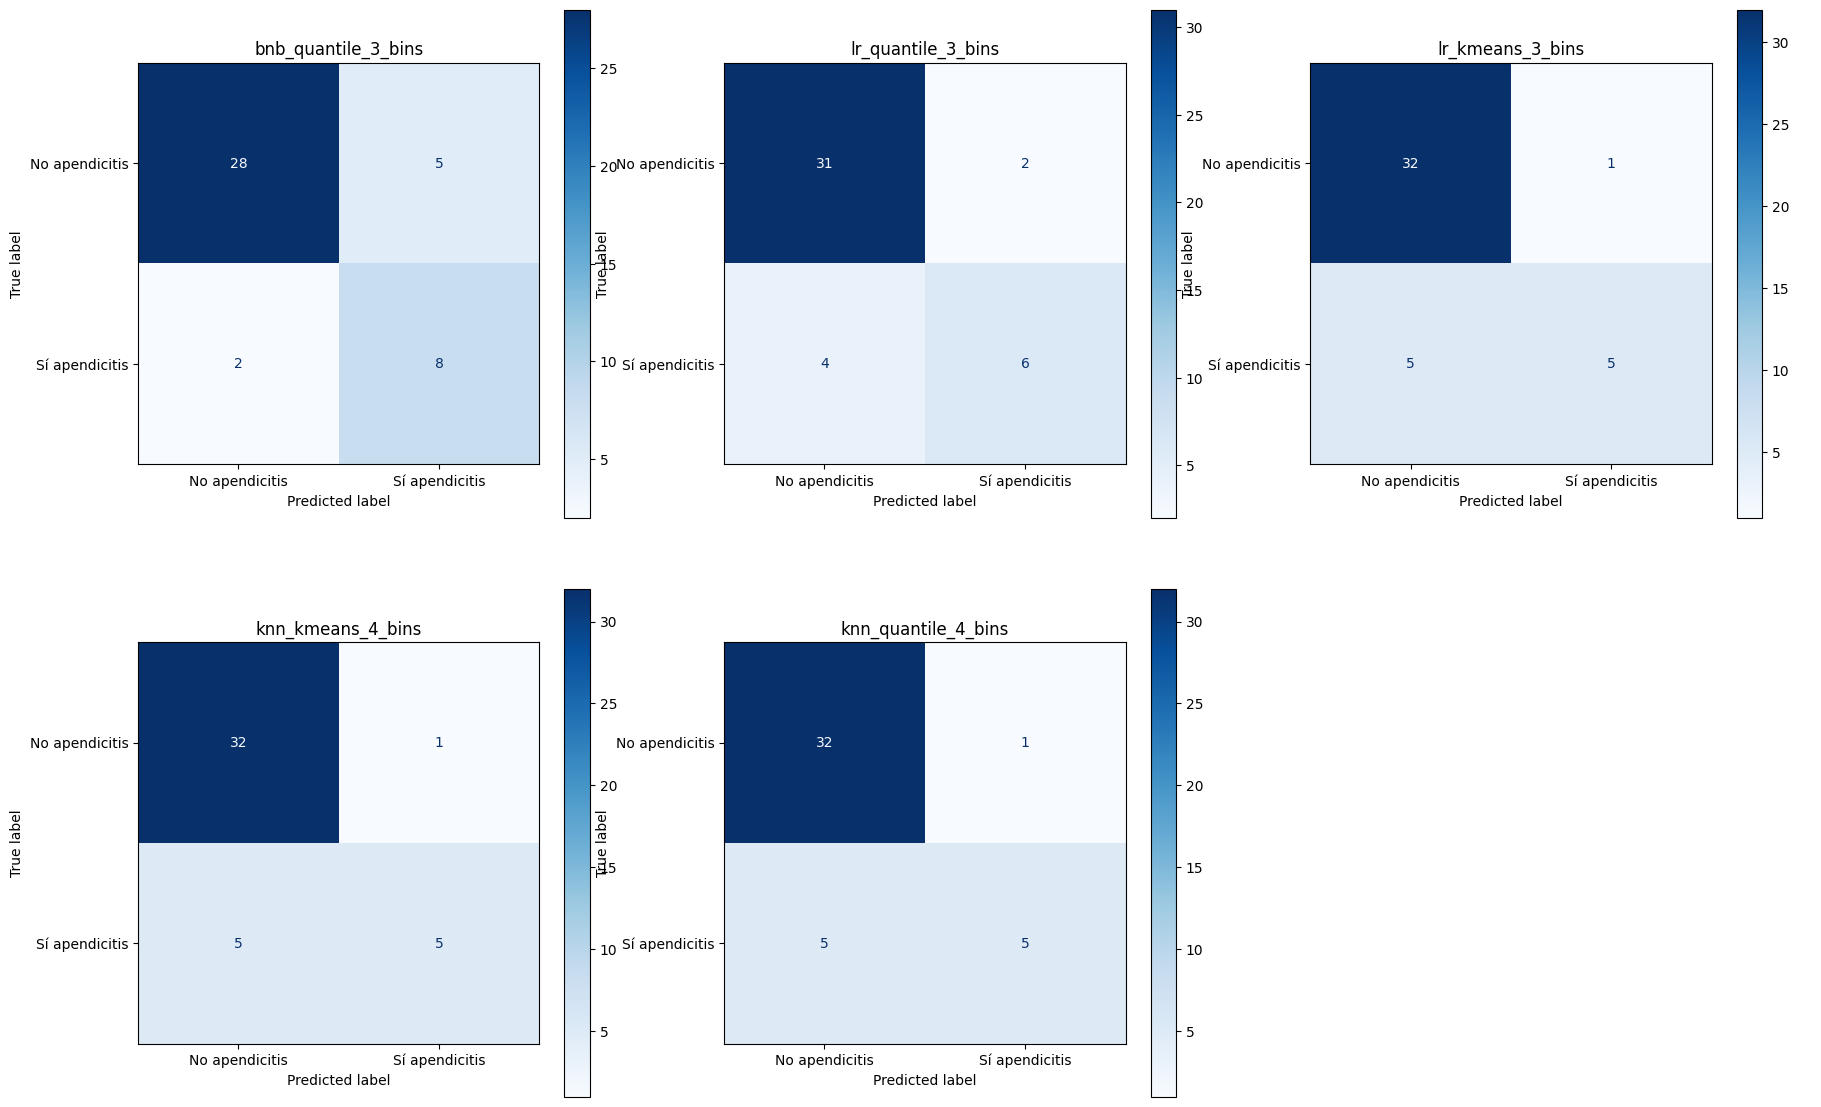

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.tight_layout(pad=3.0)

cm_disp1 = ConfusionMatrixDisplay(confusion_matrix=bnb_quantile_3_bins, display_labels=['No apendicitis', 'Sí apendicitis'])
cm_disp1.plot(cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title("bnb_quantile_3_bins")

cm_disp2 = ConfusionMatrixDisplay(confusion_matrix=lr_quantile_3_bins, display_labels=['No apendicitis', 'Sí apendicitis'])
cm_disp2.plot(cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title("lr_quantile_3_bins")

cm_disp3 = ConfusionMatrixDisplay(confusion_matrix=lr_kmeans_3_bins, display_labels=['No apendicitis', 'Sí apendicitis'])
cm_disp3.plot(cmap='Blues', ax=axes[0, 2])
axes[0, 2].set_title("lr_kmeans_3_bins")

cm_disp4 = ConfusionMatrixDisplay(confusion_matrix=knn_kmeans_4_bins, display_labels=['No apendicitis', 'Sí apendicitis'])
cm_disp4.plot(cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title("knn_kmeans_4_bins")

cm_disp5 = ConfusionMatrixDisplay(confusion_matrix=knn_quantile_4_bins, display_labels=['No apendicitis', 'Sí apendicitis'])
cm_disp5.plot(cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title("knn_quantile_4_bins")

axes[1, 2].axis('off')

plt.show()

En estas tablas vemos el rendimiento de los modelos. Las filas superiores representan los casos reales sin apendicitis y las inferiores con apendicitis. Las columnas indican nuestras predicciones.

Si consideramos prioritario minimizar la errónea asignación de no tener apendicitis, el mejor modelo es bnb_quantile_3_bins.

Pero, si buscamos un balance más equitativo, lr_quantile_3_bins es la mejor opción ya que mantiene el mismo rendimiento general que el resto, pero encima tiene una menor tassa de error para la asignación de no tener apendicitis. En caso de darnos igual la tassa de error de la asignación de no tener apendicitis, lr_kmeans_3_bins, knn_kmeans_4_bins y knn_quantile_4_bins són igual de buenos.

## Apartado D
**Teniendo en cuenta la interpretabilidad de los modelos, ¿crees que tiene ventajas el trabajar con datos discretizados? ¿Por qué?**

Con los resultados obtenidos en los apartados B y C vemos que discretizar los datos solo mejora el rendimiento de la Regresión Logística al aplicar el quantile_3_bins o kmeans_3_bins, llegando a un acierto de test del 86'0%. Pero este porcentaje es el mismo que se obtiene con los datos no discretizados con Naive Bayes o KNN. Por tanto, dado que la discretización no mejora (o incluso empeora) el rendimiento de los modelos, parece que los beneficios en términos de interpretabilidad no compensan la pérdida de rendimiento.